In [1]:
%pylab inline
import radvel

import corner
import copy

from scipy import optimize
rc('savefig',dpi=120)

# Convenient function for plotting fits
def plot_results(like):
    fig = gcf()
    errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    plot(ti, like.model(ti))
    xlabel('Time')
    ylabel('RV')
    draw()

Populating the interactive namespace from numpy and matplotlib


/Users/bjfulton/anaconda3/lib/python3.6/site-packages/emcee-2.2.1-py3.6.egg/emcee/ptsampler.py:36: DeprecationWarning: invalid escape sequence \e
/Users/bjfulton/anaconda3/lib/python3.6/site-packages/astropy/extern/bundled/six.py:60: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/bjfulton/anaconda3/lib/python3.6/site-packages/astropy/extern/bundled/six.py' mode='r' encoding='utf-8'>
  class X(object):
/Users/bjfulton/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/bjfulton/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/bjfulton/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args,

Intialize Keplerian model parameters
====================================

In [2]:
params = radvel.Parameters(1,basis='per tc secosw sesinw k')
params['k1'] = radvel.Parameter(value=1)
params['per1'] = radvel.Parameter(value=1)
params['secosw1'] = radvel.Parameter(value=0.1)
params['sesinw1'] = radvel.Parameter(value=+0.2)
params['tc1'] = radvel.Parameter(value=0.)
rv_mod = radvel.RVModel(params)

Generate Synthetic Data
=======================

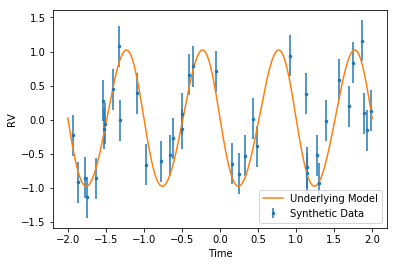

In [3]:
t = np.random.random_sample(40)
t = t * 4 - 2
t = np.sort(t)
ti = np.linspace(-2,2,400)
errvel = 0.3
jitter = 0.3
syn_rv = rv_mod(t) + randn(t.size)*np.sqrt(errvel**2 + jitter**2)
errorbar(t,syn_rv,yerr=errvel,fmt='.',label='Synthetic Data')
plot(ti,rv_mod(ti),label='Underlying Model')
xlabel('Time')
ylabel('RV')
legend()

Generate a likelihood
=====================

In [4]:
like_syn = radvel.likelihood.RVLikelihood(rv_mod,t,syn_rv,zeros(t.size)+errvel)
like_syn.params['gamma'] = radvel.Parameter(value=0)
like_syn.params['jit'] = radvel.Parameter(value=errvel)

truths = copy.deepcopy(like_syn.params) # Store away model parameters for later reference
like_syn.params.update(dict(k1=radvel.Parameter(value=3),
                            secosw1=radvel.Parameter(value=0.1),
                            sesinw1=radvel.Parameter(value=0.1),
                            tc1=radvel.Parameter(value=0.1))) # perturb the starting guess

like_syn.params['jit'].vary = False # Don't vary jitter


Perform a maximum likelihood fit
===============================

 final_simplex: (array([[ 1.00452474, -0.00432128,  0.02449722,  0.28533913,  0.75348667,
        -0.00452295, -0.00456698, -0.00372179],
       [ 1.00452281, -0.00433196,  0.02455586,  0.28526886,  0.75344523,
        -0.00452045, -0.00456486, -0.00371933],
       [ 1.00451542, -0.00433525,  0.0244743 ,  0.28537709,  0.75348442,
        -0.00452409, -0.00456805, -0.00372277],
       [ 1.00451273, -0.00434012,  0.02454559,  0.2852866 ,  0.75349464,
        -0.00452104, -0.00456539, -0.00371977],
       [ 1.00451794, -0.00431553,  0.02446108,  0.28538326,  0.7534722 ,
        -0.00452447, -0.00456823, -0.00372323],
       [ 1.00451704, -0.0043242 ,  0.0245374 ,  0.28528857,  0.7534873 ,
        -0.00452123, -0.00456545, -0.00372006],
       [ 1.00451902, -0.00432717,  0.02446776,  0.28538103,  0.75350936,
        -0.00452433, -0.00456822, -0.00372305],
       [ 1.00452768, -0.00432897,  0.02453505,  0.28529422,  0.75348492,
        -0.00452138, -0.00456568, -0.00372025],
       [ 1.0045

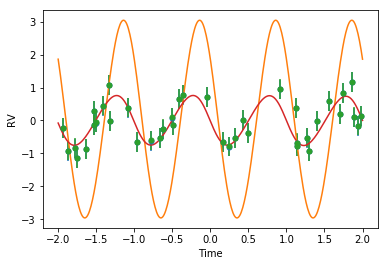

In [5]:
plot_results(like_syn) # Plot initial model
res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='Nelder-Mead' )
#res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='L-BFGS-B' )
print(res)
print(like_syn)
plot_results(like_syn) # plot best fit model

Instantiate a posterior object
===============================

In [6]:
post = radvel.posterior.Posterior(like_syn)
post.params['per1'] = radvel.Parameter(value=1)
post.params['k1'] = radvel.Parameter(value=1)
post.params['jit'].vary = True
post.priors += [radvel.prior.EccentricityPrior( 1 )]
post.priors += [radvel.prior.Gaussian( 'jit', errvel, 0.1)]
post.priors += [radvel.prior.Gaussian( 'per1', 1, 0.1)]
post.priors += [radvel.prior.Gaussian( 'tc1', 0, 0.1)]

post.priors += [radvel.prior.SecondaryEclipsePrior(1, 0.5, 0.01)]

print(post)

parameter                     value      vary
per1                              1       True
tc1                     -0.00431323       True
secosw1                   0.0244774       True
sesinw1                     0.28536       True
k1                                1       True
dvdt                    -0.00452374       True
curv                    -0.00456763       True
gamma                   -0.00372263       True
jit                             0.3       True

Priors
------
e1 constrained to be < 0.99
Gaussian prior on jit, mu=0.3, sigma=0.1
Gaussian prior on per1, mu=1, sigma=0.1
Gaussian prior on tc1, mu=0, sigma=0.1
secondary eclipse constraint: 0.5 +/- 0.01



Perform maximum likelihood fit on posterior
=========================================

['per1', 'tc1', 'secosw1', 'sesinw1', 'k1', 'dvdt', 'curv', 'gamma'] ['per1', 'tc1', 'secosw1', 'sesinw1', 'k1', 'dvdt', 'curv', 'gamma', 'jit'] [ 1.         -0.00431323  0.02447736  0.28536035  1.         -0.00452374
 -0.00456763 -0.00372263  0.3       ]


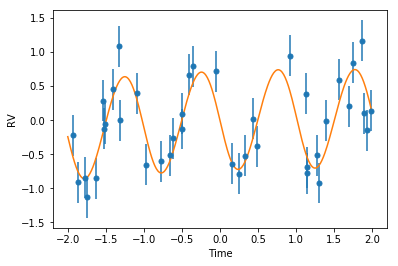

In [7]:
print(post.vparams_order, post.list_vary_params(), post.get_vary_params())
res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='Nelder-Mead' )
plot_results(post.likelihood)

Use mcmc to sample the posterior distribution
========================

1. use `emcee` package to run MCMC
1. corner plot visualizes parameters and correlations
1. Blue lines show the synthetic model parameters

In [8]:
df, minTz, maxGR = radvel.mcmc(post,nwalkers=20,nrun=1000)

8000/160000 (5.0%) steps complete; Running 33079.15 steps/s; Mean acceptance rate = 48.0%; Min Tz = 4261.1; Max G-R = 1.006      
Discarding burn-in now that the chains are marginally well-mixed

120000/160000 (75.0%) steps complete; Running 23540.20 steps/s; Mean acceptance rate = 39.4%; Min Tz = 4719.6; Max G-R = 1.006      
Chains are well-mixed after 120000 steps! MCMC completed in 5.2 seconds




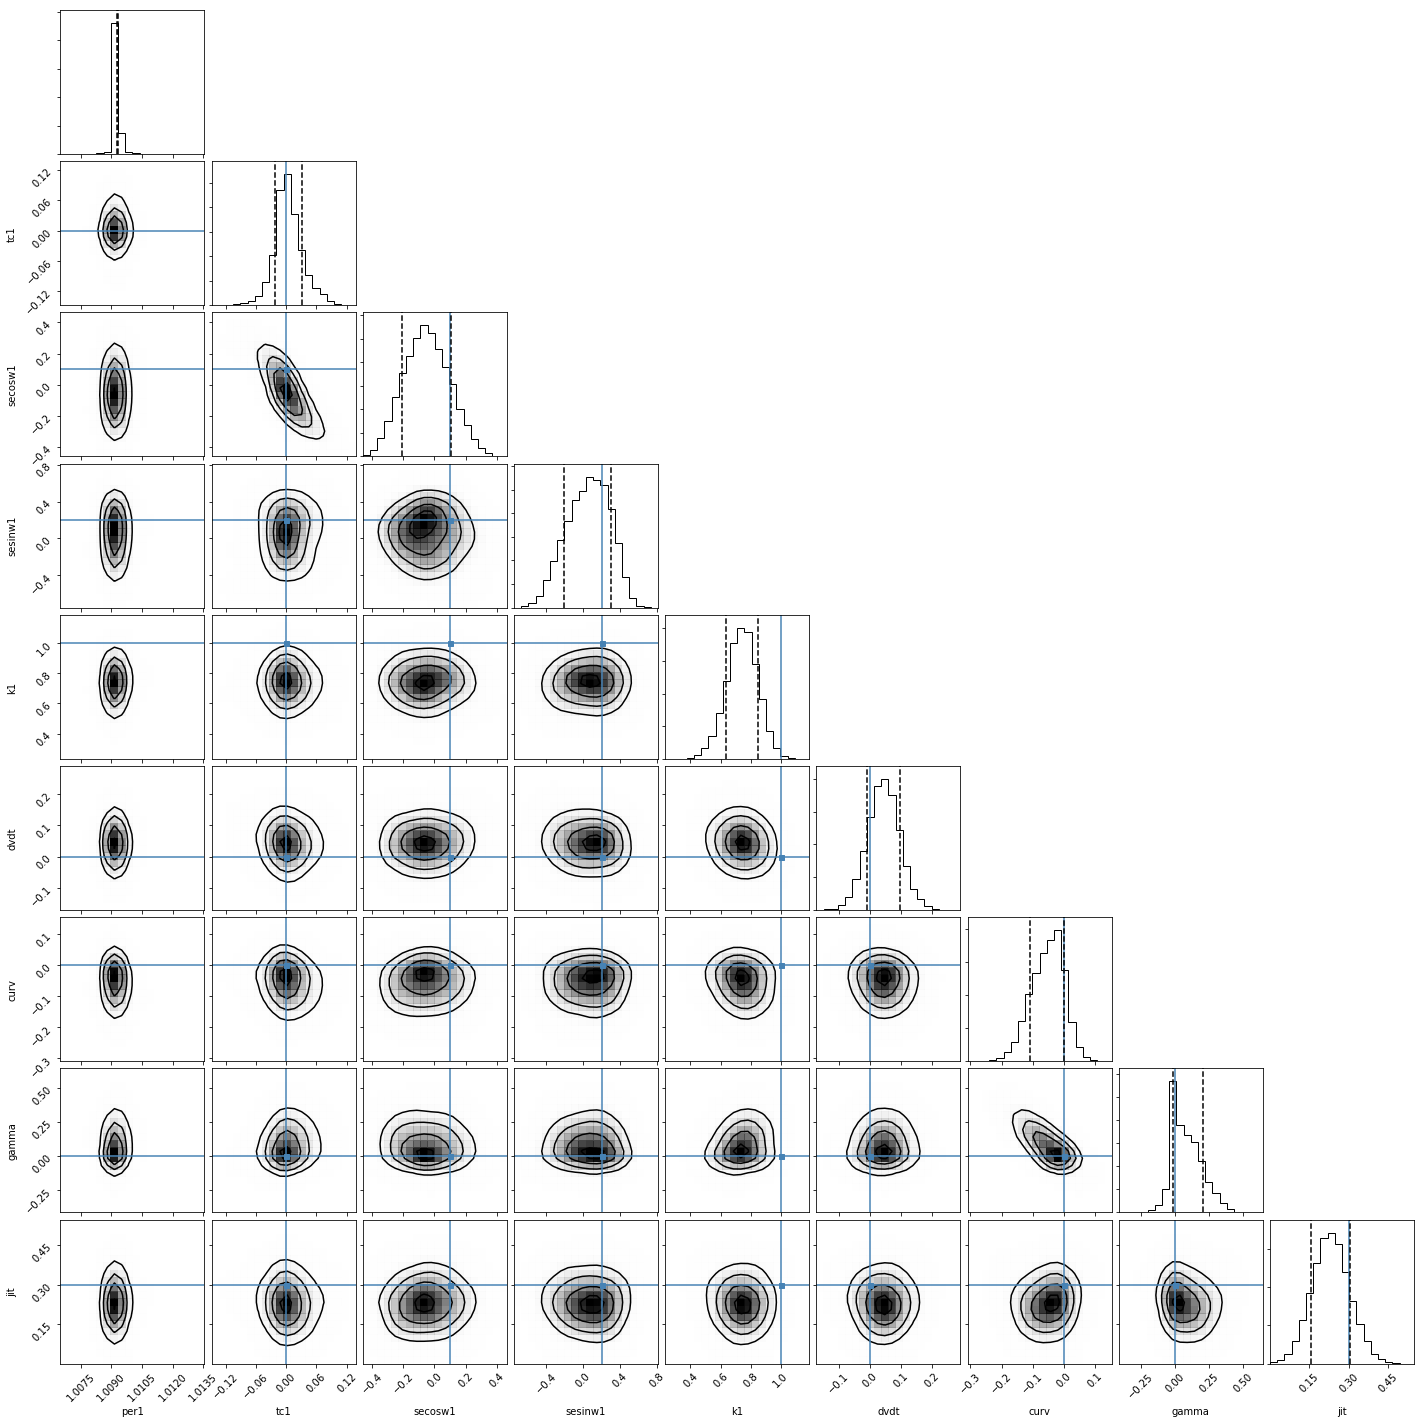

In [9]:
labels = [k for k in post.params.keys() if post.params[k].vary]



fig = corner.corner(
    df[labels],
    labels=labels,
    truths=[truths[k].value for k in labels ],
    quantiles=[0.15,0.85],
    plot_datapoints=False,
    smooth=True,
    bins=20
    )

(array([5.0000e+00, 1.5000e+01, 5.5000e+01, 3.0100e+02, 1.2470e+03,
        4.5690e+03, 1.3967e+04, 3.3281e+04, 4.3512e+04, 1.5048e+04]),
 array([-26.27244419, -24.14723594, -22.02202769, -19.89681943,
        -17.77161118, -15.64640293, -13.52119468, -11.39598642,
         -9.27077817,  -7.14556992,  -5.02036167]),
 <a list of 10 Patch objects>)

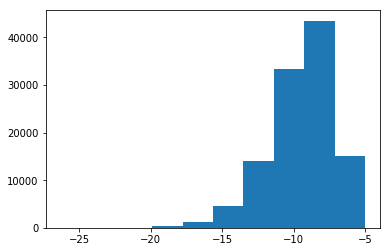

In [10]:
hist(df.lnprobability)